This notebook take inspiration from the Nvidia's [SegNet](https://github.com/dusty-nv/pytorch-segmentation/tree/master).

In [1]:
import torchvision
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.transform import resize

from math import floor
from dataclasses import dataclass
from pathlib import Path

from semantic_segmentation.dataset import get_sets as get_semantic_sets
from semantic_segmentation.dataset import InputType
from ipywidgets import interact, BoundedIntText
from utils.dataset import get_dataloader
from params import PROJECT_PATH
from sam_pipeline_utils import compute_semantic_segmentation, CostType
from semantic_segmentation.sam_pipeline_utils import downsample_to_grid
from params.dataset import TOP_UNUSED_ROWS


device = "cuda"

if device == "cuda":
    # Benchmark different convolution algorithms and use the fastest one
    torch.backends.cudnn.benchmark = True

# Config

In [2]:
@dataclass
class SegTrainingConfig:
    dataset_dir: Path = (
        PROJECT_PATH
        / "datasets/Distillation dataset/smaller_dataset_distillation_all"
    )
    weights: str = torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT
    batch_size: int = 64
    num_epochs: int = 100
    lr: float = 1e-3
    lr_max_decay: float = 0.01
    lr_decay_step: int = 50


config = SegTrainingConfig()

In [3]:
%%script false --no-raise-error

# XXX: debug
config = SegTrainingConfig(
    dataset_dir=PROJECT_PATH
    / "datasets/Distillation dataset/fake_dataset_distillation",
)

# Dataset

In [4]:
train_set, val_set, test_set = get_semantic_sets(
    config.dataset_dir,
)
train_loader, val_loader, test_loader = get_dataloader(
    train_set, val_set, test_set, batch_size=config.batch_size
)

# Model

In [5]:
torchvision.models.list_models(torchvision.models.segmentation)

['deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'fcn_resnet101',
 'fcn_resnet50',
 'lraspp_mobilenet_v3_large']

In [6]:
model = torchvision.models.segmentation.fcn_resnet50(
    weights=config.weights,
    progress=True,
)

# Adapt for our task of traversal semantic segmentation
model.classifier[-1] = torch.nn.Conv2d(
    512, 1, kernel_size=(1, 1), stride=(1, 1)
)
model.aux_classifier[-1] = torch.nn.Conv2d(
    256, 1, kernel_size=(1, 1), stride=(1, 1)
)

In [7]:
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Training

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, 1, config.lr_max_decay, config.lr_decay_step
)

In [9]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = torch.nn.functional.mse_loss(x, target.unsqueeze(1))

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = torch.tensor(0.0).to(device)
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad(set_to_none=True)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss

    avg_train_loss = total_loss.item() / len(train_loader)
    return avg_train_loss


def evaluate(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_pred_val = model(x_val)["out"]
            val_loss += torch.nn.functional.mse_loss(
                y_pred_val, y_val.unsqueeze(1)
            ).item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

In [10]:
def train_model(config, model):
    progress_bar = tqdm(range(config.num_epochs), desc="Epoch")
    train_loss_list = []
    val_loss_list = []

    for _ in progress_bar:
        train_loss = train(model, train_loader, optimizer, device)
        val_loss = evaluate(model, val_loader, device)

        lr_scheduler.step()
        progress_bar.set_description(
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch"
        )

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

    return train_loss_list, val_loss_list

In [12]:
train_loss_list, val_loss_list = train_model(config, model)

Train Loss: 1.3459, Val Loss: 0.2786, Epoch: 100%|██████████| 100/100 [36:15<00:00, 21.75s/it]


In [30]:
evaluate(model, test_loader, device)

0.33683592081069946

In [13]:
torch.save(model.state_dict(), "logs/model_new_size_data_aug.pth")

In [14]:
weights = torch.load("logs/model_new_size_data_aug.pth")
model.load_state_dict(weights)

<All keys matched successfully>

# Results?

Text(0, 0.5, 'Loss')

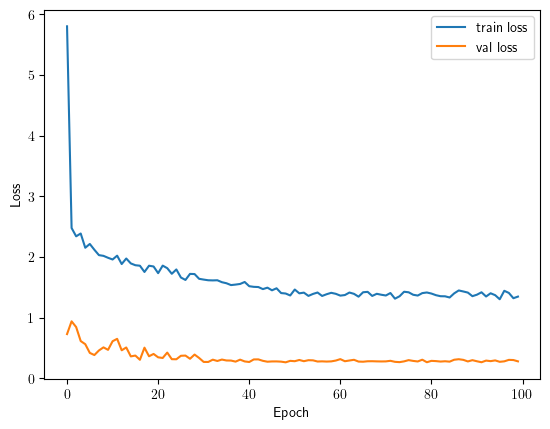

In [15]:
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [16]:
whole_image_dataset = (
    PROJECT_PATH / "datasets/Distillation dataset/dataset_distillation_all"
)

visualization_set = test_set


@interact(index=BoundedIntText(0, min=0, max=len(visualization_set) - 1))
def visualize_prediction(index):
    model.eval()
    with torch.no_grad():
        image, target = visualization_set[index]
        image = image.unsqueeze(0).to(device)
        output = model(image)["out"]

    _, axes = plt.subplots(1, 5, figsize=(30, 4))

    test_index = visualization_set.indexes[index]
    whole_image_path = config.dataset_dir / f"images/{test_index:05d}.png"
    whole_image = plt.imread(whole_image_path)
    output = output.squeeze().cpu().numpy()
    top_height = (
        floor(output.shape[0] / (1 - TOP_UNUSED_ROWS)) - output.shape[0]
    )
    axes[0].imshow(whole_image)
    axes[0].imshow(whole_image)
    axes[0].axhline(top_height, linestyle="dotted", color="red")
    axes[0].axis("off")
    axes[0].set_title("Source Image")

    axes[1].imshow(target.squeeze().numpy(), cmap="hot_r", vmin=2, vmax=6)
    axes[1].set_title("Target (SAM Pipeline)")
    axes[1].axis("off")

    colorbar = axes[2].imshow(output, cmap="hot_r", vmin=2, vmax=6)
    axes[2].set_title("Predicted Result (distillation)")
    axes[2].axis("off")

    plt.colorbar(colorbar, ax=axes, shrink=0.5, location="bottom")

    whole_target = np.load(
        whole_image_dataset / f"targets/{test_index:05d}.npy"
    )

    top_half = np.zeros((top_height, output.shape[1]))
    whole_output = np.vstack((top_half, output))

    whole_output = resize(
        whole_output,
        whole_target.shape,
        mode="reflect",
        anti_aliasing=True,
    )
    axes[3].imshow(whole_target)

    costmap_target = downsample_to_grid(whole_target)
    costmap_output = downsample_to_grid(whole_output)

    axes[3].imshow(costmap_target, cmap="hot_r", vmin=2, vmax=6)
    axes[3].set_title("Target Costmap\n(i.e. SAM Pipeline)")
    axes[3].axis("off")
    axes[4].imshow(costmap_output, cmap="hot_r", vmin=2, vmax=6)
    axes[4].set_title("Predicted Costmap\n(i.e. distillation)")
    axes[4].axis("off")

interactive(children=(BoundedIntText(value=0, description='index', max=646), Output()), _dom_classes=('widget-…

## Artefacts of bilinear upsampling

In [18]:
import inspect

print(inspect.getsource(model.forward))

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        input_shape = x.shape[-2:]
        # contract: features is a dict of tensors
        features = self.backbone(x)

        result = OrderedDict()
        x = features["out"]
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
        result["out"] = x

        if self.aux_classifier is not None:
            x = features["aux"]
            x = self.aux_classifier(x)
            x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
            result["aux"] = x

        return result



In [19]:
img, _ = train_set[0]

In [20]:
features = model.backbone(img.unsqueeze(0).to(device))

x = features["out"]
x = model.classifier(x)

x_interp = torch.nn.functional.interpolate(
    x, size=img.shape[-2:], mode="bilinear", align_corners=False
)

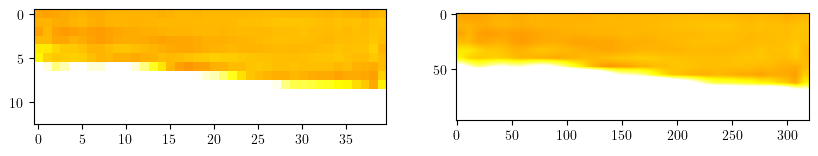

In [21]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(x.squeeze().cpu().detach().numpy(), cmap="hot_r", vmin=2, vmax=6)
ax2.imshow(
    x_interp.squeeze().cpu().detach().numpy(), cmap="hot_r", vmin=2, vmax=6
)

# Benchmarking models

## Distilled model

In [22]:
from timeit import timeit

model.eval()
benchmark_image, _ = test_set[0]
benchmark_image = benchmark_image.unsqueeze(0).to(device)

In [23]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    model(benchmark_image)

## Full SAM pipeline

In [24]:
def get_image(img_path: Path) -> np.array:
    with Image.open(img_path) as pil_img:
        pil_img = pil_img.resize((180, 320))
        return np.array(pil_img)


img = get_image(config.dataset_dir / "images" / "00000.png")
depth = get_image(config.dataset_dir / "images" / "00000d.png")
normal = get_image(config.dataset_dir / "images" / "00000n.png")

In [25]:
%%script false --no-raise-error
%%timeit

with torch.no_grad():
    compute_semantic_segmentation(
        img,
        depth,
        normal,
        should_fill_segmentation=True,
        cost_type=CostType.CENTERED,
        should_filter_intersection=True,
        completeness_threshold=0,
    )

## Plot

Text(0.5, 1.0, 'Comparison of SAM_pipeline and distilled_pipeline')

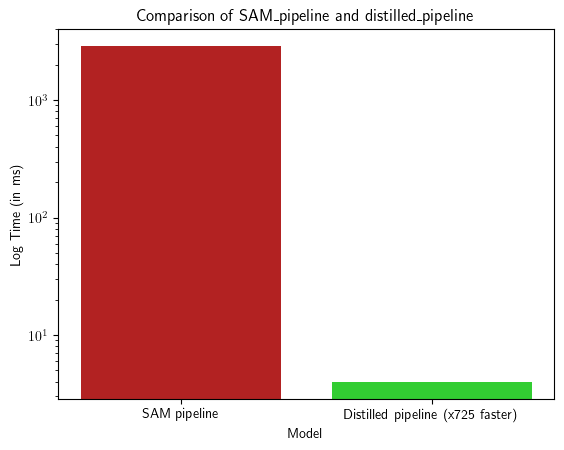

In [26]:
# %%script false --no-raise-error

# XXX: time written below are computed with the 2 above %%timeit
sam_pipeline_time = 2900
distilled_pipeline_time = 4

values = [sam_pipeline_time, distilled_pipeline_time]
labels = [
    "SAM pipeline",
    f"Distilled pipeline (x{sam_pipeline_time // distilled_pipeline_time} faster)",
]

plt.bar(labels, values, color=["firebrick", "limegreen"])
plt.xlabel("Model")
plt.ylabel("Log Time (in ms)")
plt.yscale("log")
plt.title("Comparison of SAM_pipeline and distilled_pipeline")

# Profiling Training

In [13]:
from torch.profiler import profile, ProfilerActivity, record_function

In [14]:
%%script false --no-raise-error

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    with_stack=True,
) as prof:
    train(model, train_loader, optimizer, device)

STAGE:2023-12-18 14:53:21 26902:26902 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-12-18 14:53:41 26902:26902 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-12-18 14:53:41 26902:26902 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [18]:
%%script false --no-raise-error

prof.export_chrome_trace("trace_non_blocking.json")